## Enhancements and Analysis - Outcome Prediction

The process mining package for python pm4py allows the seamlesss intergration of classical machine learning models into our anaylsis through the sci-kit learn package. This enables us to not only predict outcomes and classify and cluseter traces but also to perform root cause analysis on why a certain path or outcome took place.

These lind of investiagtions would be seen as both analaysis and enahancements in the PM$^2$ pathway below <sup>[1]</sup>.

In our ambulance job cycle data, we might be interested in predicting if a patient will need to be taken to hospital early in the job cycle. Therefore we set about integrating some classic machine learning modele with our event log to predict whether pateints were going to be taken to hospital while also wanting to undertand which attributes might infleuice this prediction the most.


[1]Van Eck, M. L., Lu, X., Leemans, S. J. & Van Der Aalst, W. M. (2015), Pm: a process mining project
methodology, in ‘International conference on advanced information systems engineering’, Springer, pp. 297–
313.

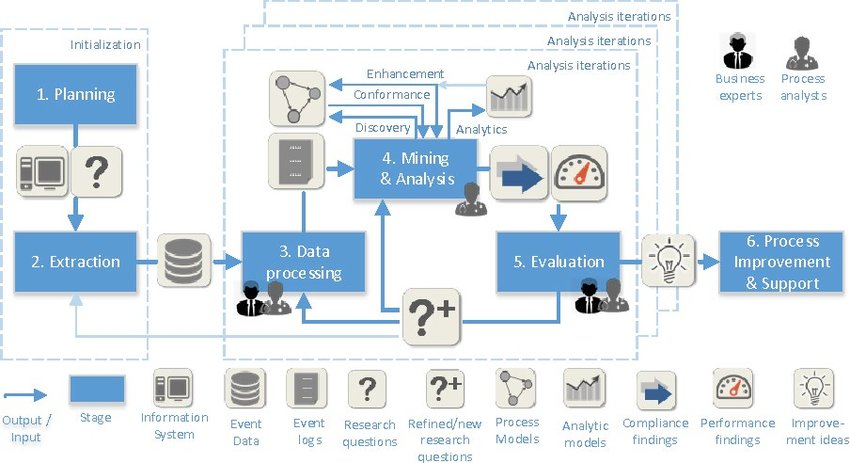

In [1]:
from IPython.display import Image, display
display(Image(filename='PM2_Process-Mining-Project-Methodology.png'))

In python we import open source packages with useful functions that will facillitate our programming

In [2]:
import pandas as pd
import re
import numpy as np
import pm4py
import seaborn as sns
from matplotlib import pyplot as plt
import math
import random

We download our pre-prepared event log

In [3]:
EL_df0=pd.read_csv('EventLogWAttsBusRules.csv')
EL_df0[['Timestamp']] = EL_df0[['Timestamp']].apply(pd.to_datetime, errors='coerce')
EL_df0.Patient_ID.nunique()

5435

## Data Pre-Processing
the next steps acomplish the following objectives
- add features to the dataframe (hour of the day'day of the week for each event)
- make the data only include events between the start and our chosen cut off point to make a prediction of a patients outcome from
- add the outcome as the end event to predict from the data before it
- make the string fo the days column cagtegorical


We are going to perform some transformatins on our event log so it is smart to make a copy now so that we can revert any changes to if required by rerunning the below cell.

In [4]:
EL_df1=EL_df0.copy()

add hour of the day of the week to dataframe

In [5]:
EL_df1['hour'] = EL_df1['Timestamp'].apply(lambda x: x.time().hour)
EL_df1['day'] = EL_df1['Timestamp'].dt.dayofweek

This function cuts off our traces in the event log at a chosen activity so that we ensure to only uses data prior to that activity to make our prediction. For example if we were to predict that a patient will be taken to hospital while having used data fro mthe entire trace that shows the patient had already been taken to hospital then that would not be useful.

Innstead, haveing dicsussed our aims with the clinical experts we decied that our cut off point would be the firss measurement of NEWs to make our prediction as the amabualance staff on scene may still be deciding the outcome of the patient after this event.

In [6]:
def predictoutcomeafternamedevent(df,namedevent):
    #find patients who actually complete the named event
    pidevent=list(df.loc[df['Activity']==namedevent]['Patient_ID'].values)
    #filter dataframe to only cinlude those patients
    df=df[df['Patient_ID'].isin(pidevent)]
    #reset index of dataframe
    df=df.reset_index(drop=True)
    # find index position of the first event of each patient
    y=[np.min(df.index[df['Patient_ID']==i].tolist()) for i in df.Patient_ID.unique()]
    # find index position of the named event in each patients trace
    z=df.loc[df['Activity']==namedevent].index.values.tolist()
    # get indexes of all events between the start of each patients trace and the named event
    c=[np.arange(i,j+1) for i,j in zip(y,z)]
    df2=df.copy()
    # make new data frame  ony includeing the events that happend between the start of and named event of each trace
    df2=df2.iloc[[x for lst in c for x in lst]]
    ids=list(df2.loc[df['Activity']=='Depart_scene']['Patient_ID'].values)
    df2=df2[~df2['Patient_ID'].isin(ids)]
    return df2


Use the above function. To predict outcome we are interested in predicting form either the 'Arrive_Scene' or 'First_NEWS' event.

In [7]:
EL_df2=predictoutcomeafternamedevent(EL_df1,'First_NEWS_Time')

add outcome as event to event log after the last event

In [8]:
x=[np.max(EL_df2.index[EL_df2['Patient_ID']==i].tolist()) for i in EL_df2.Patient_ID.unique()]
ELend_df = EL_df2.iloc[EL_df2.index.isin(x)]
ELend_df['Activity']=ELend_df['Outcome']

C:\Users\User\AppData\Local\Temp\ipykernel_31652\1948328273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ELend_df['Activity']=ELend_df['Outcome']


In [9]:
ELend_df['Timestamp']=ELend_df['Timestamp'] + pd.Timedelta(1,'s')
EL_df2=pd.concat([EL_df2, ELend_df], axis=0)
EL_df2= EL_df2.sort_values(['Patient_ID','Timestamp'])

C:\Users\User\AppData\Local\Temp\ipykernel_31652\985259418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ELend_df['Timestamp']=ELend_df['Timestamp'] + pd.Timedelta(1,'s')


In [10]:
EL_df2['day'] = np.where(EL_df2['day'] == 0, 'Monday',EL_df2['day'])
EL_df2['day'] = np.where(EL_df2['day'] == '1', 'Tuesday',EL_df2['day'])
EL_df2['day'] = np.where(EL_df2['day'] == '2', 'Wednesday',EL_df2['day'])
EL_df2['day'] = np.where(EL_df2['day'] == '3', 'Thursday',EL_df2['day'])
EL_df2['day'] = np.where(EL_df2['day'] == '4', 'Friday',EL_df2['day'])
EL_df2['day'] = np.where(EL_df2['day'] == '5', 'Saturday',EL_df2['day'])
EL_df2['day'] = np.where(EL_df2['day'] == '6', 'Sunday',EL_df2['day'])

Some classifiers cannot handle NaN in continous variables. Here we remove patients who dont have a curated Age of NEWS value so that classifiers that cannot interpet a NaN as a missing variable can be used to predict outcome

In [11]:
print('Patients in Event Log with fianl event(Arrive on AScnec of Firts NEWS)',EL_df2.Patient_ID.nunique())
EL_df2=EL_df2[~EL_df2['Age'].isna()]
print('Patients remaining with curated Age:' ,EL_df2.Patient_ID.nunique())
EL_df2=EL_df2[~EL_df2['First NEWS'].isna()]
print('Patients remaining with curated NEWS',EL_df2.Patient_ID.nunique())
EL_df2=EL_df2[~EL_df2['Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)'].isna()]
print('Patients remaining with curated IMD',EL_df2.Patient_ID.nunique())

Patients in Event Log with fianl event(Arrive on AScnec of Firts NEWS) 1907
Patients remaining with curated Age: 1907
Patients remaining with curated NEWS 1907
Patients remaining with curated IMD 1889


make an event log object of the log

In [12]:
EL_df2 = pm4py.format_dataframe(EL_df2,case_id='Patient_ID', activity_key='Activity', timestamp_key='Timestamp',)
EL_Outcome_log = pm4py.convert_to_event_log(EL_df2)

C:\Users\User\AppData\Local\Temp\ipykernel_31652\3240646960.py:1: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  EL_df2 = pm4py.format_dataframe(EL_df2,case_id='Patient_ID', activity_key='Activity', timestamp_key='Timestamp',)
C:\Users\User\Anaconda3\envs\PM_env\Lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In [13]:
EL_df2.Outcome.unique()

array(['Deceased Not Transported', 'Deceased and Transported',
       'Treated & Transported', 'Alt Transport',
       'Referred to Other Medical'], dtype=object)

visualise the directly follows graph for the filtered log which only includes events between the start of the log, the named event cut off point and the final outcome.

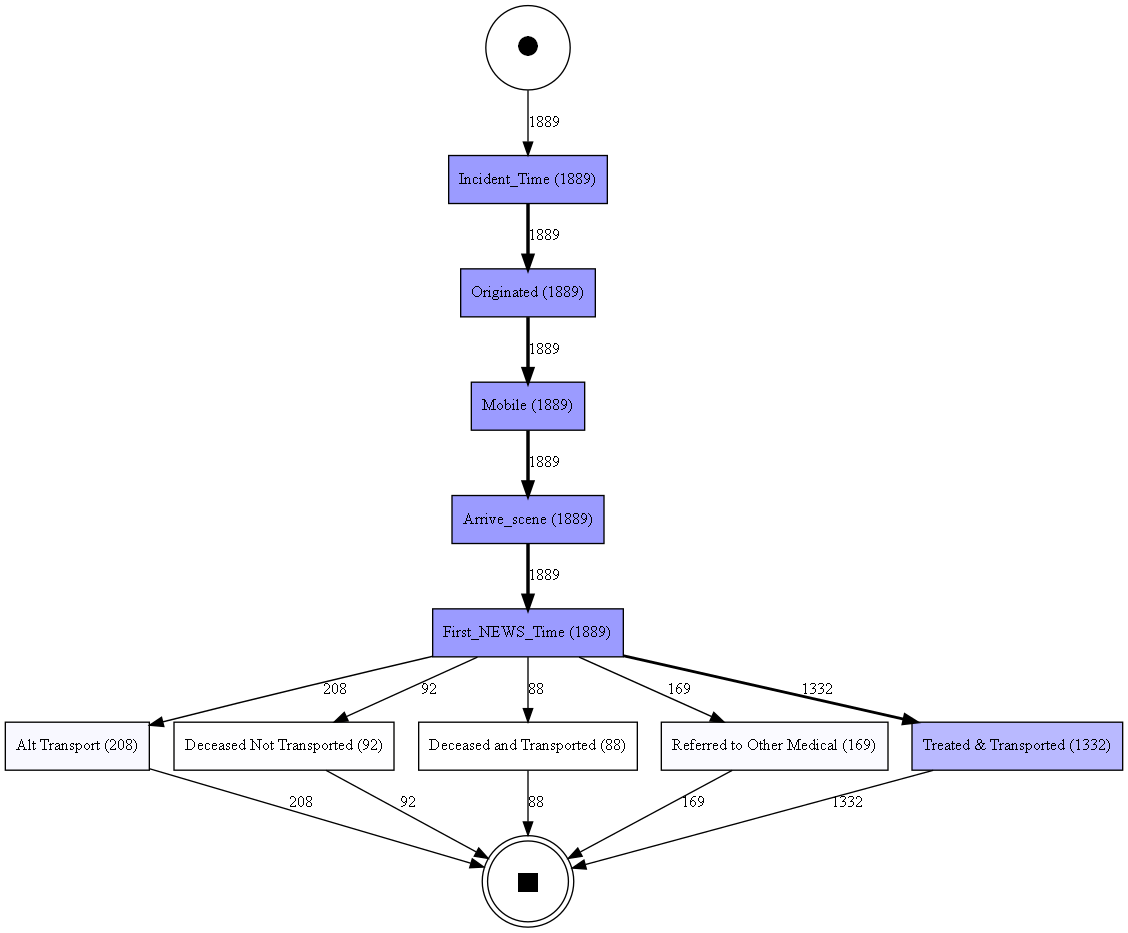

In [14]:
dfg, start_activities, end_activities = pm4py.discover_dfg(EL_Outcome_log)
pm4py.view_dfg(dfg, start_activities, end_activities)

### Separate the traces into classes to Predict Outcome

In the pm4py we can quickly label the traces by their final activity which we have made their repective outcomes.

In [15]:
from pm4py.objects.log.util import get_class_representation
target, classes = get_class_representation.get_class_representation_by_str_ev_attr_value_value(EL_Outcome_log, "concept:name")


In [55]:
EL_df1.columns

Index(['Unnamed: 0', 'Patient_ID', 'Activity', 'Timestamp', 'Age', 'Sex',
       'Ethnicity', 'Incident_Postcode', 'Clinical Category',
       'Highest Technician on Scene', 'First NEWS', 'Last_NEWS',
       'Event Location', 'Outcome', 'PCDS', 'LSOA11CD', 'LSOA code (2011)',
       'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)',
       'Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)',
       'Geographical Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs)',
       'Crime Decile (where 1 is most deprived 10% of LSOAs)',
       'Income Decile (where 1 is most deprived 10% of LSOAs)',
       'Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)',
       'Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)',
       'hour', 'day'],
      dtype='object')

here we manually select features or attibutes from the event log. Categorical variables are one hot encoded.

In [56]:
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features
data, feature_names = log_to_features.apply(EL_Outcome_log, parameters={"str_tr_attr": [], "str_ev_attr": ["concept:name",'Highest Qual On Scene','Sex','Event Location','day','Clinical Category'], "num_tr_attr": [], "num_ev_attr": ['hour','Age','First NEWS','Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)',
       'Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)',
       'Geographical Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs)',
       'Crime Decile (where 1 is most deprived 10% of LSOAs)',
       'Income Decile (where 1 is most deprived 10% of LSOAs)',
       'Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)',
       'Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)']})#,"str_evsucc_attr": ["concept:name"]})

make a  copy of the data and feature names so that we can revert changes

In [57]:
data1=data
feature_names1=feature_names

view feature names

In [58]:
print(feature_names1)

['event:concept:name@Alt Transport', 'event:concept:name@Arrive_scene', 'event:concept:name@Deceased Not Transported', 'event:concept:name@Deceased and Transported', 'event:concept:name@First_NEWS_Time', 'event:concept:name@Incident_Time', 'event:concept:name@Mobile', 'event:concept:name@Originated', 'event:concept:name@Referred to Other Medical', 'event:concept:name@Treated & Transported', 'event:Highest Qual On Scene@UNDEFINED', 'event:Sex@Female', 'event:Sex@Male', 'event:Event Location@Home', 'event:Event Location@Not Home', 'event:day@Friday', 'event:day@Monday', 'event:day@Saturday', 'event:day@Sunday', 'event:day@Thursday', 'event:day@Tuesday', 'event:day@Wednesday', 'event:Clinical Category@Cardiovascular', 'event:Clinical Category@Mental Health', 'event:Clinical Category@Neurological', 'event:Clinical Category@Obs/Gynae', 'event:Clinical Category@Respiratory', 'event:Clinical Category@Trauma', 'event:hour', 'event:Age', 'event:First NEWS', 'event:Index of Multiple Deprivation 

remove unwanted features.
- These include the features of the outcome event theselves which we should not train off
- Minority features that are only present in a small minority of patients making them highly identifiable and allow a model to overfit to them

In [59]:
'event:concept:name@Treated & Transported', 'event:concept:name@Alt Transport','event:concept:name@Referred to Other Medical', 'event:concept:name@Deceased Not Transported','event:concept:name@Deceased and Transported'

('event:concept:name@Treated & Transported',
 'event:concept:name@Alt Transport',
 'event:concept:name@Referred to Other Medical',
 'event:concept:name@Deceased Not Transported',
 'event:concept:name@Deceased and Transported')

In [60]:
unwantedfeatures=['event:concept:name@Treated & Transported', 'event:concept:name@Alt Transport','event:concept:name@Referred to Other Medical', 'event:concept:name@Deceased Not Transported','event:concept:name@Deceased and Transported','event:concept:name@Arrive_Dest','event:concept:name@Care_Transfer','event:concept:name@Depart_Scene']
uwind=[]
for i in unwantedfeatures:
    if i in feature_names1:
        uwind.append(feature_names1.index(i))
    
print(uwind)
for i in data1:
    for index in sorted(uwind, reverse=True):
        del i[index]
for index in sorted(uwind, reverse=True):
    del feature_names1[index]

[9, 0, 8, 2, 3]


view features after the removal of unwanted features

In [61]:
print('new number of feautures:',len(feature_names1))
feature_names1

new number of feautures: 33


['event:concept:name@Arrive_scene',
 'event:concept:name@First_NEWS_Time',
 'event:concept:name@Incident_Time',
 'event:concept:name@Mobile',
 'event:concept:name@Originated',
 'event:Highest Qual On Scene@UNDEFINED',
 'event:Sex@Female',
 'event:Sex@Male',
 'event:Event Location@Home',
 'event:Event Location@Not Home',
 'event:day@Friday',
 'event:day@Monday',
 'event:day@Saturday',
 'event:day@Sunday',
 'event:day@Thursday',
 'event:day@Tuesday',
 'event:day@Wednesday',
 'event:Clinical Category@Cardiovascular',
 'event:Clinical Category@Mental Health',
 'event:Clinical Category@Neurological',
 'event:Clinical Category@Obs/Gynae',
 'event:Clinical Category@Respiratory',
 'event:Clinical Category@Trauma',
 'event:hour',
 'event:Age',
 'event:First NEWS',
 'event:Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)',
 'event:Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)',
 'event:Geographical Barriers Sub-domain Decile (w

Build our training dataset as 66% of the data

In [27]:
trainindices=random.sample([i for i, x in enumerate(target)],int(math.ceil(len(target)*0.66)))
traindata=[data[i] for i in trainindices]
trainlabels=[target[i] for i in trainindices]


Build our testing data set as the remaining 33% of the data

In [28]:
x=range(len(data))
testindices=list(set(x).difference(trainindices))
#testindices
testdata=[data[i] for i in testindices]
testlabels=[target[i] for i in testindices]

### Decsion Tree - Predict Outcome

install decision tree package

In [29]:
from sklearn import tree
from pm4py.visualization.decisiontree import visualizer as dectree_visualizer

C:\Users\User\Anaconda3\envs\PM_env\Lib\site-packages\pm4py\visualization\decisiontree\__init__.py:21: UserWarning: The decisiontree visualizer will be removed in a future release (use Scikit Learn instead).
  warnings.warn("The decisiontree visualizer will be removed in a future release (use Scikit Learn instead).")


fit decision tree model

In [30]:
clf = tree.DecisionTreeClassifier(max_depth=15,min_samples_leaf=5)
clf.fit(traindata, trainlabels)
#clf.fit(data, target)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=5)

Get accuracy on test set

In [31]:
clf.predict(traindata, check_input=True)
sum(clf.predict(testdata, check_input=True)==testlabels)/len(testlabels)

0.5856697819314641

Plot Tree. a smaller tree with less depth is easier to read

[Text(0.7217318936713837, 0.96875, 'event:First NEWS <= 17.5\ngini = 0.474\nsamples = 1247\nvalue = [59, 56, 883, 135, 114]\nclass = Treated & Transported'),
 Text(0.5157908313679245, 0.90625, 'event:Clinical Category@Cardiovascular <= 0.5\ngini = 0.459\nsamples = 1124\nvalue = [52, 50, 810, 117, 95]\nclass = Treated & Transported'),
 Text(0.2544590212264151, 0.84375, 'event:Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs) <= 3.5\ngini = 0.435\nsamples = 883\nvalue = [39, 36, 652, 89, 67]\nclass = Treated & Transported'),
 Text(0.14661949685534592, 0.78125, 'event:Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs) <= 6.0\ngini = 0.477\nsamples = 245\nvalue = [9, 8, 172, 35, 21]\nclass = Treated & Transported'),
 Text(0.1403301886792453, 0.71875, 'event:Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs) <= 3.5\ngini = 0.459\nsamples = 236\nvalue = [8, 7, 169, 34, 18]\nclass = Treated & Transp

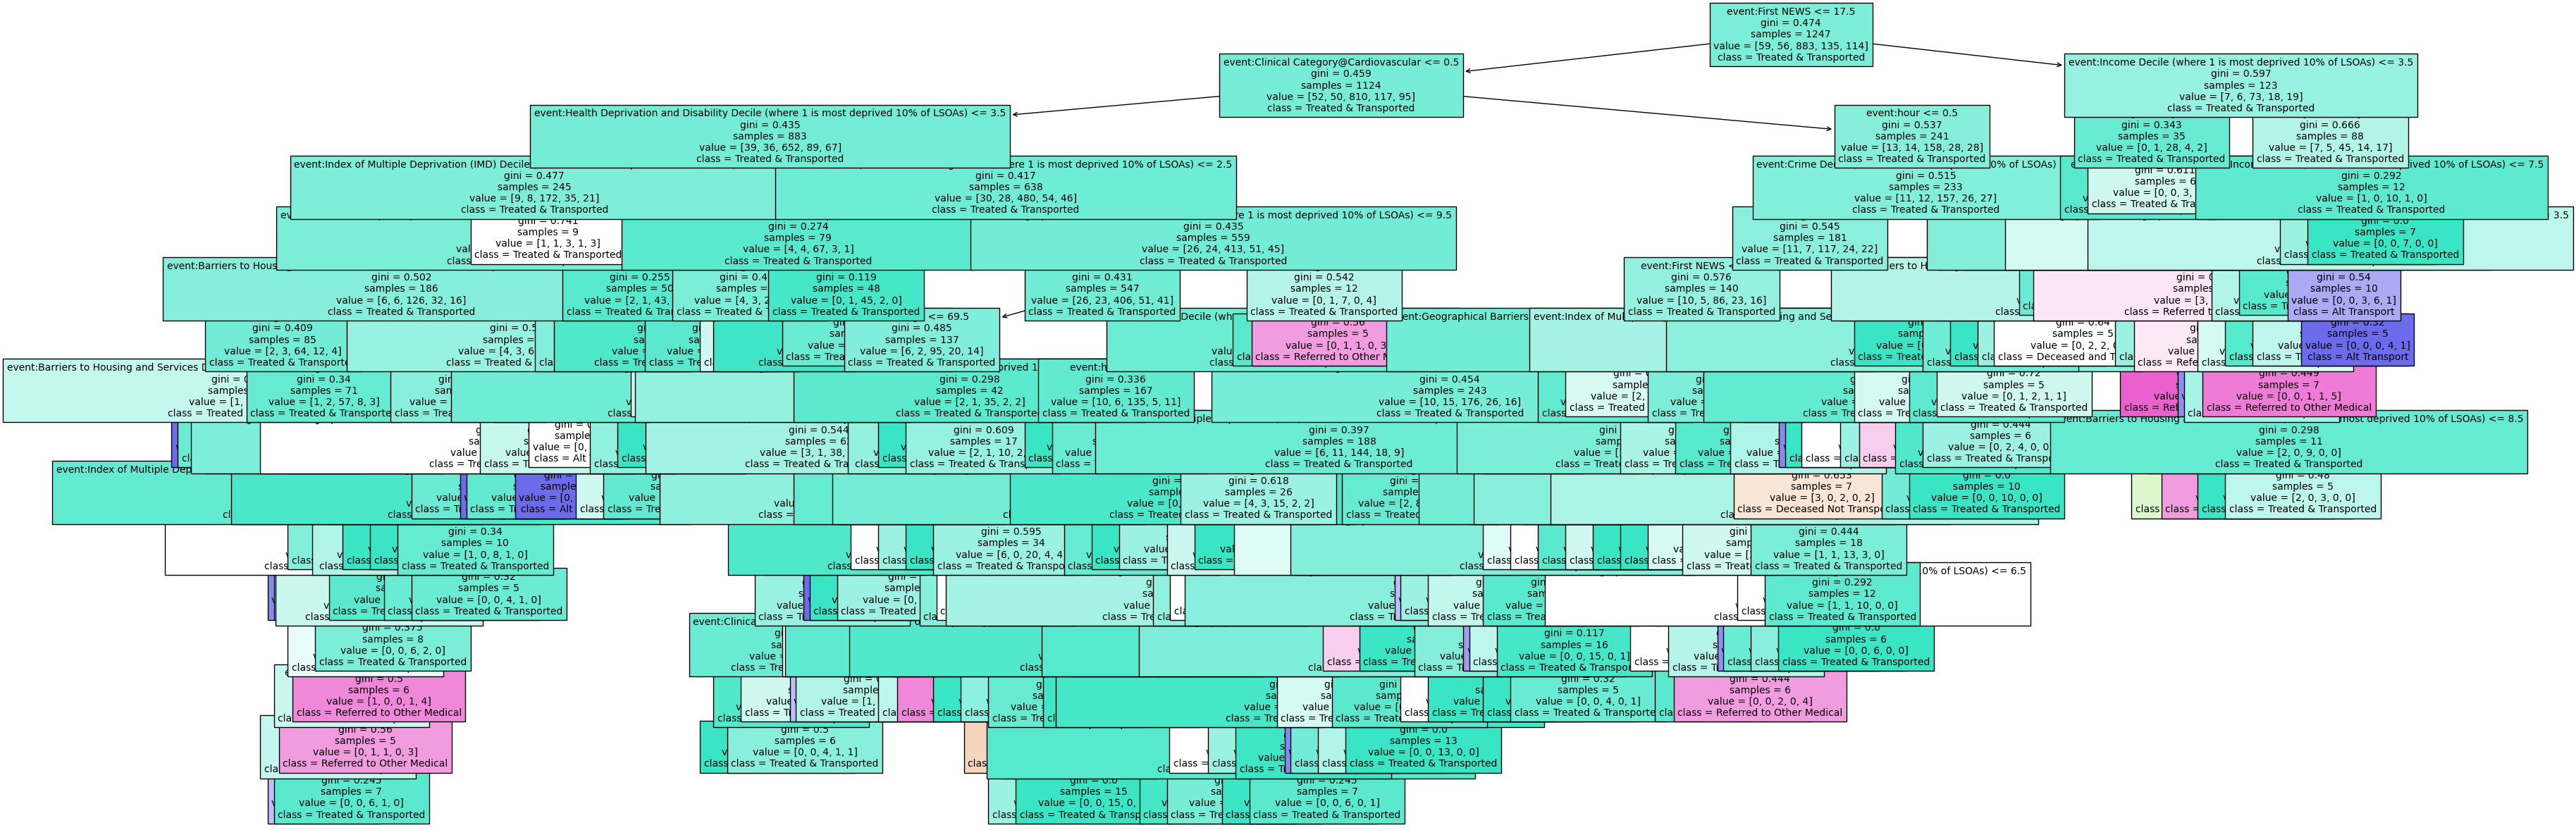

In [32]:
plt.figure(figsize=(40,15))
tree.plot_tree(clf,feature_names=feature_names1,fontsize=10,filled=True,class_names=classes)

### Root cause analysis

We can evaluate the input features using their importance in the classifcation of the outcome in the training set. The higher the importance of the feature, the more influence it had on the classifier when predicting the outcome of the patient.

In [33]:
FI={'Feature':feature_names1,'Importance':clf.feature_importances_}
FI_df = pd.DataFrame(FI)
FI_df=FI_df.sort_values('Importance',axis=0, ascending=False)
FI_df.head(44)
FI_df.Feature=FI_df.Feature.str.split('@').str[0]
FI_df=pd.DataFrame(FI_df.groupby('Feature')['Importance'].sum())
FI_df=FI_df.sort_values('Importance',axis=0, ascending=False)
FI_df.head(44)

,Importance
Feature,
event:Age,0.198177
event:hour,0.138943
event:First NEWS,0.131889
event:day,0.119398
event:Geographical Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs),0.083926
event:Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),0.082178
event:Crime Decile (where 1 is most deprived 10% of LSOAs),0.072730
event:Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),0.066711
event:Income Decile (where 1 is most deprived 10% of LSOAs),0.039053


View a confusion matrix of the test set

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

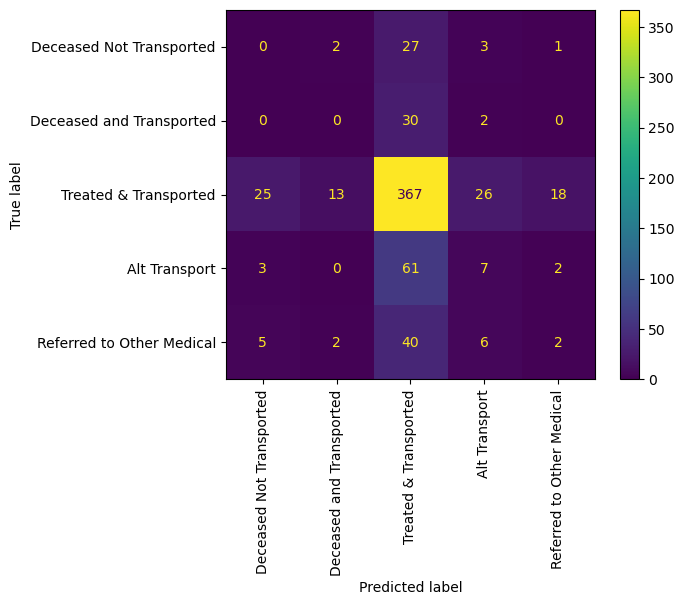

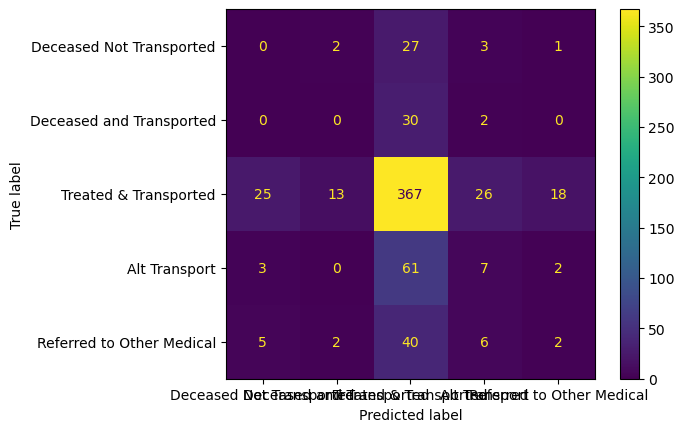

In [35]:
disp = ConfusionMatrixDisplay.from_predictions(testlabels,clf.predict(testdata, check_input=True),display_labels=classes,xticks_rotation='vertical')
disp.plot()
#plt.show()

Calculate macro F1 score

In [63]:
print('Decision Tree Macro F1 score: ',f1_score(testlabels,clf.predict(testdata,check_input=True), average='macro'))

Decision Tree Macro F1 score:  0.18490672001965638


### Random Forest - Predict Outcome

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
rfm = RandomForestClassifier(n_estimators=500,max_depth=15, random_state=0,min_samples_leaf=5)
rfm.fit(traindata, trainlabels)

RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=500,
                       random_state=0)

Get accuracy on test set

In [40]:
sum(rfm.predict(testdata)==testlabels)/len(testlabels)

0.6993769470404985

View a confusion matrix of the test set

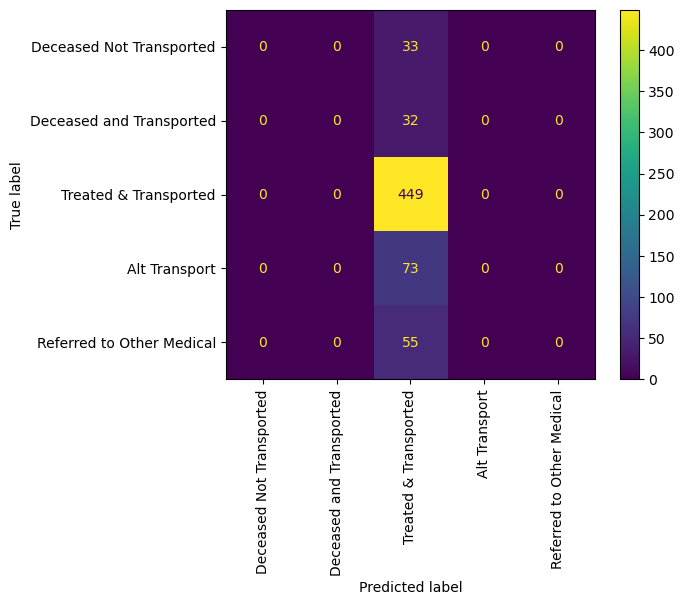

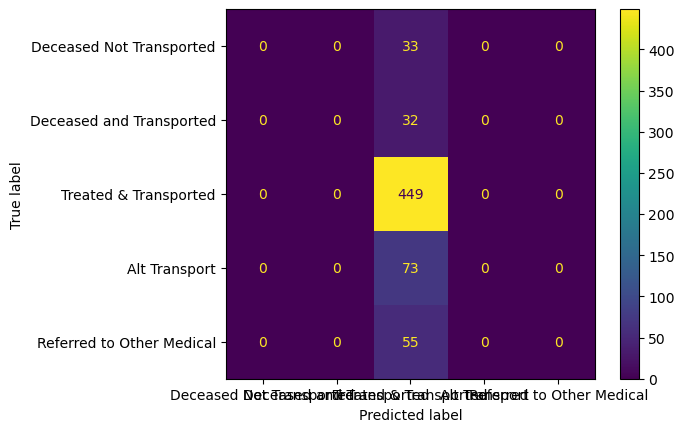

In [41]:
disp = ConfusionMatrixDisplay.from_predictions(testlabels,rfm.predict(testdata),display_labels=classes,xticks_rotation='vertical')
disp.plot()

Calculate macro F1 score

In [43]:
print('Random Forest Macro F1 score: ',f1_score(testlabels,clf.predict(testdata,check_input=True), average='macro'))

Random Forest Macro F1 score:  0.18490672001965638


### Root cause analysis

We can evaluate the input features using their importance in the classifcation of the outcome in the training set. The higher the importance of the feature, the more influence it had on the classifier when predicting the outcome of the patient.

In [44]:
FI={'Feature':feature_names1,'Importance':rfm.feature_importances_}
FI_df = pd.DataFrame(FI)
FI_df=FI_df.sort_values('Importance',axis=0, ascending=False)
FI_df.head(30)

,Feature,Importance
22,event:Age,0.136153
23,event:First NEWS,0.119696
21,event:hour,0.116220
30,event:Barriers to Housing and Services Decile ...,0.070082
27,event:Crime Decile (where 1 is most deprived 1...,0.069982
26,event:Geographical Barriers Sub-domain Decile ...,0.064268
25,event:Health Deprivation and Disability Decile...,0.062348
28,event:Income Decile (where 1 is most deprived ...,0.061820
24,event:Index of Multiple Deprivation (IMD) Deci...,0.060345
29,"event:Education, Skills and Training Decile (w...",0.056402


### Logitsic Regression- Predict Outcome

In [45]:
from sklearn.linear_model import LogisticRegression

Fit a Logistic Regression model to the training set

In [46]:
lgclf = LogisticRegression( max_iter=1000).fit(traindata, trainlabels)

C:\Users\User\Anaconda3\envs\PM_env\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Get accuracy on test set

In [47]:
sum(lgclf.predict(testdata)==testlabels)/len(testlabels)

0.6993769470404985

View a confusion matrix of the test set

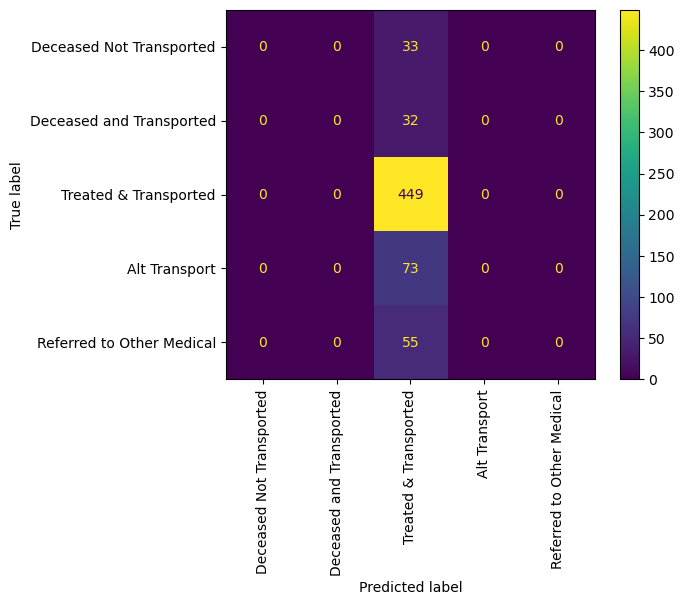

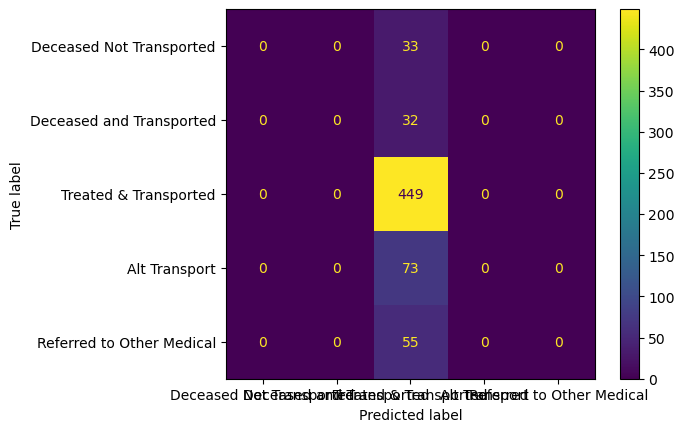

In [48]:
disp = ConfusionMatrixDisplay.from_predictions(testlabels,lgclf.predict(testdata),display_labels=classes,xticks_rotation='vertical')
disp.plot()

### Root cause analysis

We can evaluate the input features using the coefficients in the GLM model. The greater the magnitude of coefficient the more influence it had on the classifier when predicting the outcome of the patient.

In [49]:
coefs=(lgclf.coef_).tolist()[0]
posneg=[i>=0 for i in coefs]
posneg
lgcoef={'Feature':feature_names1,'Coeficients':[abs(i) for i in coefs],'Positive':posneg}
lgcoef_df = pd.DataFrame(lgcoef)
lgcoef_df=lgcoef_df.sort_values('Coeficients',axis=0, ascending=False)
lgcoef_df.head(50)

,Feature,Coeficients,Positive
14,event:day@Wednesday,0.862618,False
13,event:day@Tuesday,0.413531,False
12,event:day@Thursday,0.278069,False
9,event:day@Monday,0.223507,True
11,event:day@Sunday,0.215784,False
16,event:Clinical Category@Mental Health,0.207484,True
8,event:day@Friday,0.205356,False
24,event:Index of Multiple Deprivation (IMD) Deci...,0.192941,False
10,event:day@Saturday,0.166853,False
26,event:Geographical Barriers Sub-domain Decile ...,0.149954,False


Calculate F1 score of Binary class

In [50]:
print('Logistic Regression Macro F1 score: ',f1_score(testlabels,lgclf.predict(testdata), average='macro'))

Logistic Regression Macro F1 score:  0.16461961503208067
